In [1]:
# for debug
%reload_ext autoreload
%autoreload 2

In [2]:
from pascode import PASCode
import scanpy as sc
import torch
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
import random
import anndata
import numpy as np
import pandas as pd
import pyreadr

import matplotlib.pyplot as plt

torch.manual_seed(2022)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

device = torch.device('cpu')

In [3]:
############################################################################### 
################################### Data reading ##############################
###############################################################################
data_path = '/home/athan/projects/PASCode/data/mit.self.org.RData'
print("Reading data...")
rdata = pyreadr.read_r(data_path)

Reading data...


In [ ]:
############################################################################### 
################################### Data preprocessing ########################
###############################################################################
print('Preprocessing data...')
gxp = pd.concat([rdata['gexpr_AD'], rdata['gexpr_CTL']])
lab = pd.concat([rdata['AD_cells'], rdata['CTL_cells']])
lab.index=lab.TAG
# phenotype is AD(1)/CTL(0)
lab['AD'] = [1]*rdata['gexpr_AD'].shape[0] + [0]*rdata['gexpr_CTL'].shape[0]
# select Highly Variable Genes from gene expression data
print("Selecting HVGs...")
agxp = anndata.AnnData(gxp)
sc.pp.highly_variable_genes(agxp, min_mean=.0125, max_mean=3, min_disp=.25)
gxp = gxp.loc[:, agxp.var.highly_variable]
# scaling
print("Scaling...")
scaler = preprocessing.StandardScaler().fit(gxp)
scaled_features = scaler.transform(gxp)
X = pd.DataFrame(scaled_features, columns=gxp.columns, index=gxp.index)
print("Data preprocessing completed.")

Preprocessing data...
Selecting HVGs...
Scaling...
Data preprocessing completed.


In [ ]:
############################################################################### 
######################### train, test, validation sets ########################
###############################################################################
def get_id_pheno(lab, pheno_name):
    """
    Get subjectID/sampleID - phenotype label indexed dataframe.
    """
    group = lab.groupby(['subjectID', pheno_name]).size()
    group = group[group>0] # filtering
    id_pheno = group.index.to_frame()
    return id_pheno

# get sample IDs and phenotypes (list)
id_pheno = get_id_pheno(lab, pheno_name='AD')
# validation set: 8 donors with subjectID and AD labels
val_size = 4
val_set = pd.DataFrame({
    'subjectID':random.sample(list(id_pheno[id_pheno['AD']==0].subjectID), val_size) 
           + random.sample(list(id_pheno[id_pheno['AD']==1].subjectID), val_size),
    'phenotype':[0]*val_size + [1]*val_size})
# train/test set: 40 donors with subjectID and AD labels
train_test_set = id_pheno[~(id_pheno['subjectID'].isin(val_set['subjectID']))]
X = X[lab['subjectID'].isin(train_test_set['subjectID']).values]
lab = lab[lab['subjectID'].isin(train_test_set['subjectID'])]

In [ ]:
############################################################################### 
############################### Performance Analysis ##########################
###############################################################################
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

def evaluate_pascode(psc, X, y, id):
    # use model to get donor cluster fraction matrix from traininig data
    X_new = psc.get_donor_cluster_fraction_matrix(X, id)

    # get donor labels
    info = pd.DataFrame({
        'id':id,
        'label':y
    })
    y_true = info.groupby(['id', 'label']).size().index.to_frame()['label'].to_list()

    # clf = LogisticRegression().fit(X_new_train, y_true_train)
    clf = RandomForestClassifier().fit(X_new, y_true)
    y_pred = clf.predict(X_new)

    print("Precision:", precision_score(y_true, y_pred))
    print("Recall score:", recall_score(y_true, y_pred))
    print("F1 score:", f1_score(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC-AUC score:", roc_auc_score(y_true, clf.predict_proba(X_new)[:, 1]))

In [12]:
############################################################################### 
############################### Cross validation ##############################
############################################################################### 
# prepare data
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cv_acc = np.array([])
iter_num = 0

for train_index, test_index in skf.split(train_test_set['subjectID'], train_test_set['AD']):
    iter_num += 1
    print('#'*39 + " Fold " + str(iter_num) + ' ' + '#'*39)
    print("Training index:", train_index, "\ntraining index:", test_index)

    train_sample = [train_test_set['subjectID'][i] for i in train_index]
    test_sample = [train_test_set['subjectID'][i] for i in test_index]
    train_filter = lab['subjectID'].isin(train_sample).values
    test_filter = lab['subjectID'].isin(test_sample).values

    X_train = torch.tensor(X.loc[train_filter].values).float().to(device)
    lab_train = lab[train_filter]
    id_train = lab_train['subjectID'].values
    y_train = torch.tensor(lab_train['AD'].values)
    X_test = torch.tensor(X.loc[test_filter].values).float().to(device)
    lab_test = lab[test_filter]
    id_test = lab_test['subjectID'].values
    y_test = torch.tensor(lab_test['AD'].values)
    
    # use model
    psc = PASCode()
    psc.train(X_train, y_train)

    # perforamce
    print("Evaluation on training:")
    evaluate_pascode(psc, X=X_train, y=y_train, id=id_train)
    print("Evaluation on testing:")
    evaluate_pascode(psc, X=X_test, y=y_test, id=id_test)

####################################### Fold 1 #######################################
Training index: [ 1  2  6  8  9 10 13 14 15 16 20 21 27 28 29 30 32 33 37 38] 
Testing index: [ 0  3  4  5  7 11 12 17 18 19 22 23 24 25 26 31 34 35 36 39]
Pretraining...
epoch 0	 loss=0.8735
epoch 1	 loss=0.5864
epoch 2	 loss=0.4959
epoch 3	 loss=0.4110
epoch 4	 loss=0.3647
epoch 5	 loss=0.3320
epoch 6	 loss=0.3113
Initializing cluster centroids...
Pretraining complete.

Training...
----- 	 ------------ 	 ------------- 	 ------------
epoch 	 (total) loss 	 reconstr loss 	 entropy loss
----- 	 ------------ 	 ------------- 	 ------------
    0 	 0.77868 	 0.01180 	  0.28827 	  	 0.67017 
    1 	 0.78178 	 0.01187 	  0.27910 	  	 0.66386 
    2 	 0.74685 	 0.01220 	  0.27346 	  	 0.64778 
    3 	 0.74015 	 0.01217 	  0.27077 	  	 0.62605 
    4 	 0.72666 	 0.01189 	  0.26896 	  	 0.59715 
    5 	 0.73984 	 0.01157 	  0.26715 	  	 0.57119 
    6 	 0.71241 	 0.01190 	  0.26716 	  	 0.52972 
Training comp

In [45]:
############################################################################### 
################################## performance analysis #######################
############################################################################### 
# use model to get donor cluster fraction matrix from traininig data
X_new_train = psc.get_donor_cluster_fraction_matrix(X_train, id_train)

# get donor labels
info_train = pd.DataFrame({
    'id':id_train,
    'label':y_train
})
y_true_train = info.groupby(['id', 'label']).size().index.to_frame()['label'].to_list()

# get donor cluster fraction matrix from testing data
X_new_test = psc.get_donor_cluster_fraction_matrix(X_test, id_test)
# get donor labels 
info_test = pd.DataFrame({
    'id':id_test,
    'label':y_test
})
y_true_test = info.groupby(['id', 'label']).size().index.to_frame()['label'].to_list()

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# training data
# clf = LogisticRegression().fit(X_new_train, y_true_train)
clf = RandomForestClassifier().fit(X_new_train, y_true_train)
y_pred_train = clf.predict(X_new_train)

print("Precision:", precision_score(y_true_train, y_pred_train))
print("Recall score:", recall_score(y_true_test, y_pred_train))
print("F1 score:", f1_score(y_true_test, y_pred_train))
print("Accuracy:", accuracy_score(y_true_test, y_pred_train))
print("ROC-AUC score:", roc_auc_score(y_true_train, clf.predict_proba(X_new_train)[:, 1]))

Precision: 1.0
Recall score: 1.0
F1 score: 1.0
Accuracy: 1.0
ROC-AUC score: 1.0


In [112]:
# test data
y_pred_test = clf.predict(X_new_test)
print("Precision:", precision_score(y_true_test, y_pred_test))
print("Recall score:", recall_score(y_true_test, y_pred_test))
print("F1 score:", f1_score(y_true_test, y_pred_test))
print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("ROC-AUC score:", roc_auc_score(y_true_test, clf.predict_proba(X_new_test)[:, 1]))

Precision: 0.9
Recall score: 0.9
F1 score: 0.9
Accuracy: 0.9
ROC-AUC score: 0.935


In [84]:
############################################################################### 
################################## Visualization ##############################
############################################################################### 
embd_train = psc.get_embedding(X_train, reducer='umap')
embd_test = psc.get_embedding(X_test, reducer='umap')

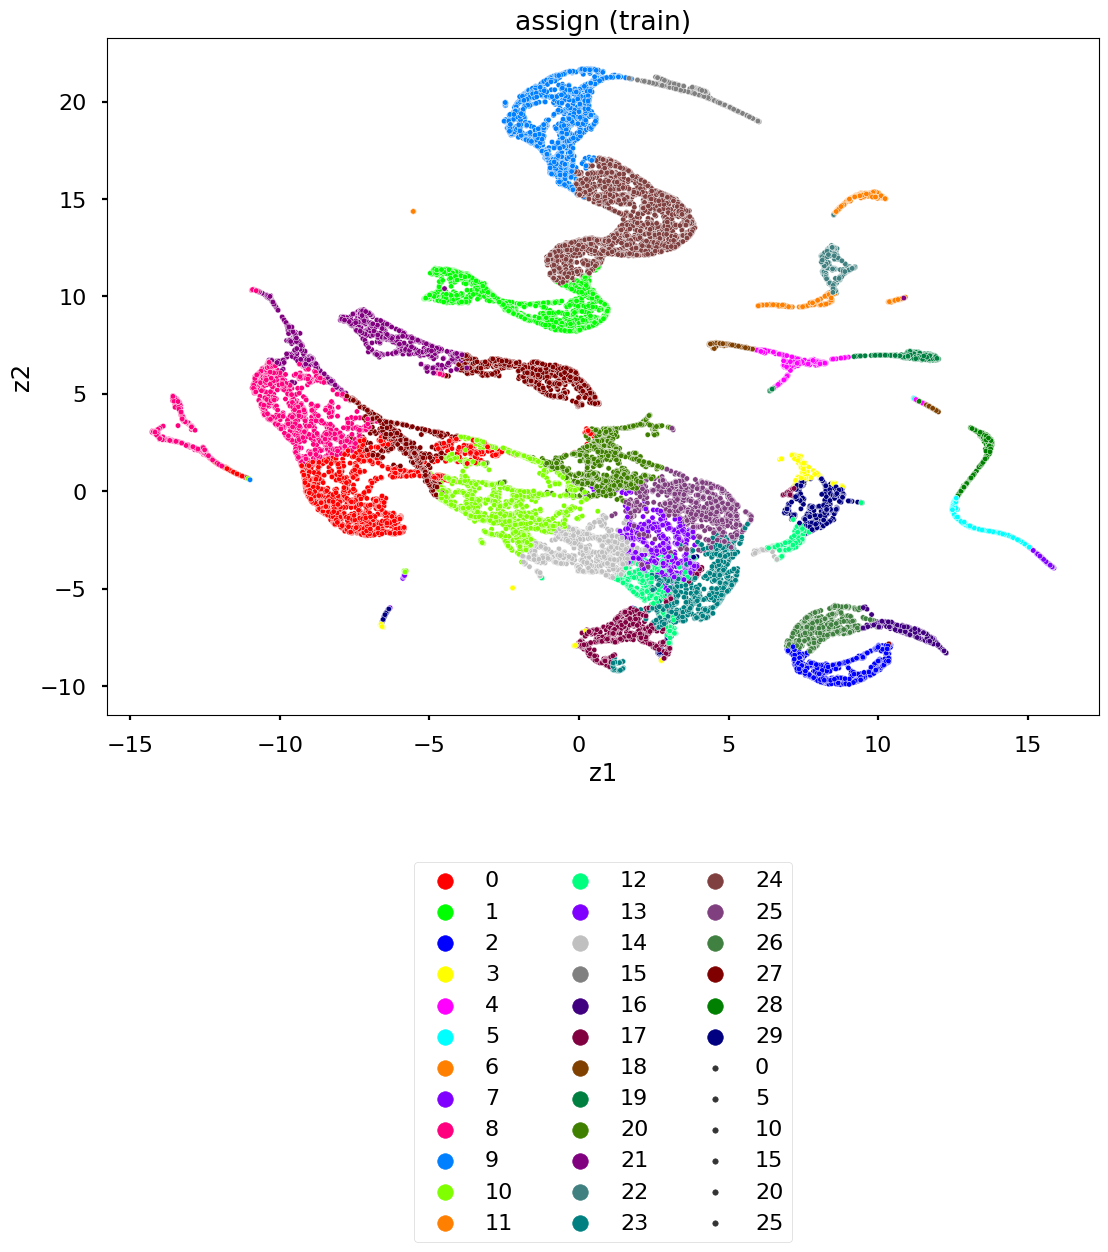

In [95]:
# On training data
lab_train['assign'] = psc.get_assigns(X_train)
psc.plot_embedding(X=embd_train, y=lab_train['assign'].values, label='assign', title='assign (train)', require_distinguishable_colors=True)

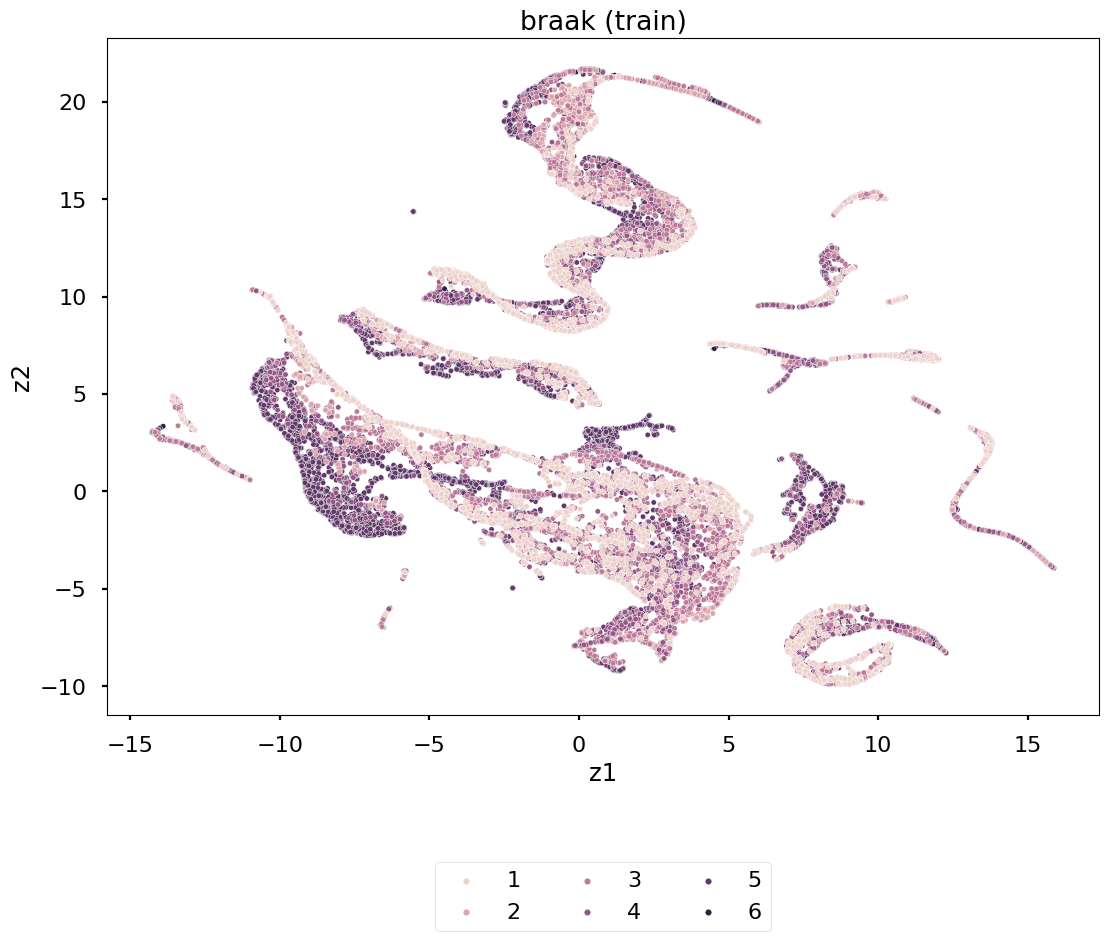

In [94]:
psc.plot_embedding(X=embd_train, y=lab_train['braaksc'].values, label='braak', title='braak (train)', require_distinguishable_colors=False)

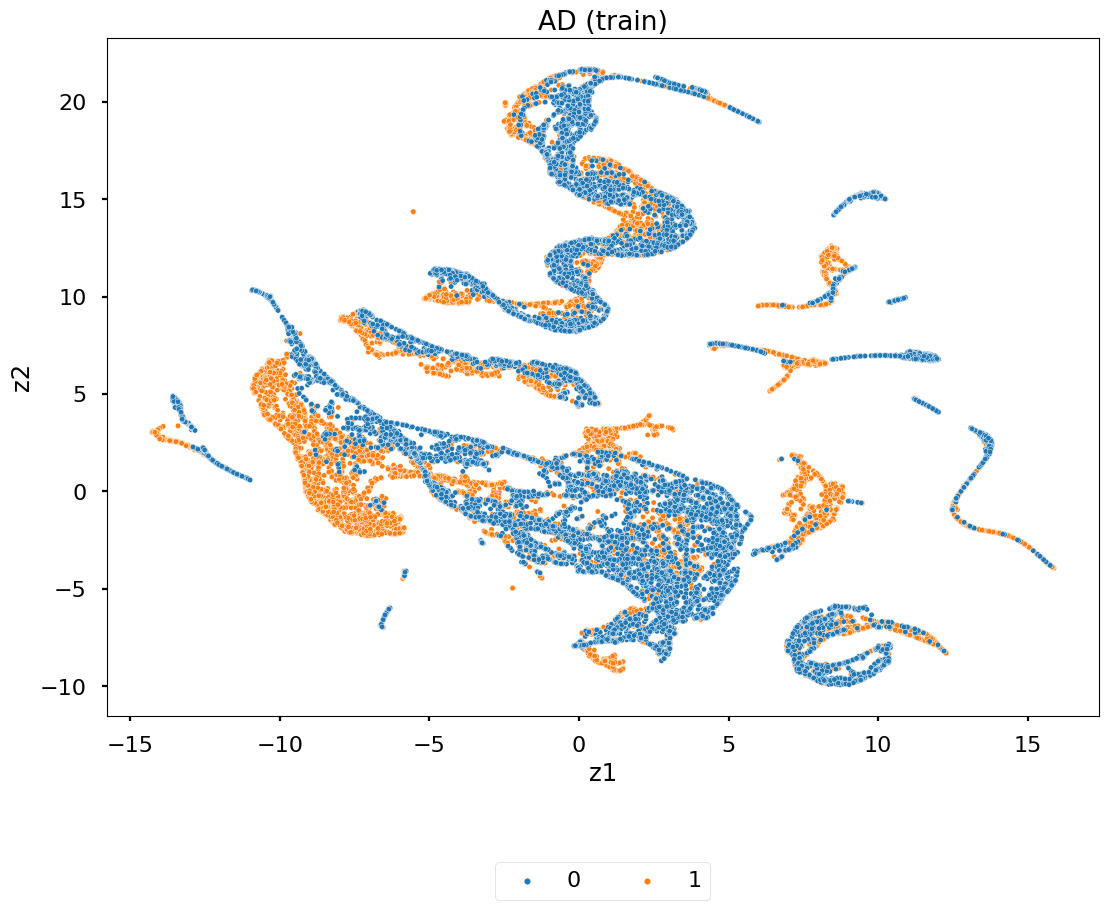

In [93]:
psc.plot_embedding(X=embd_train, y=lab_train['AD'].values, label='AD', title='AD (train)', require_distinguishable_colors=False)

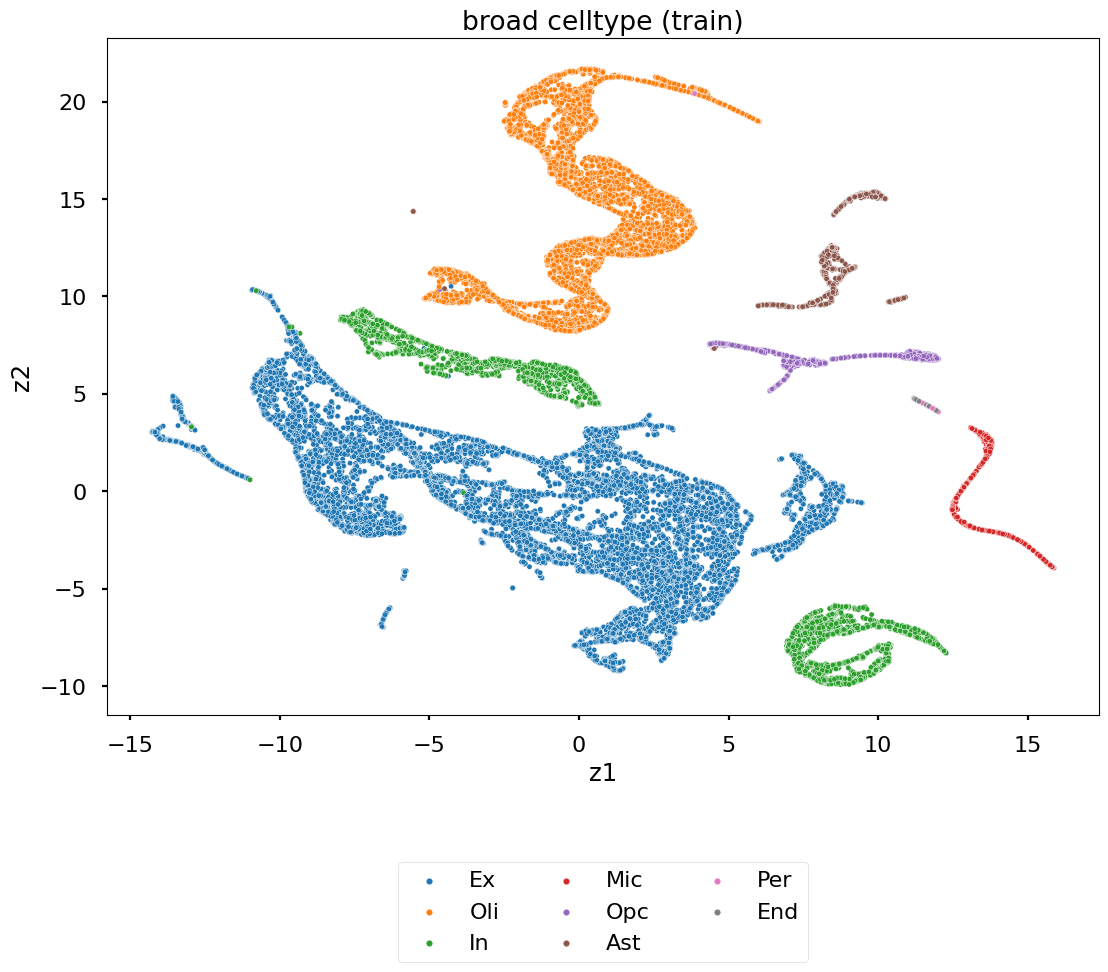

In [92]:
psc.plot_embedding(X=embd_train, y=lab_train['broad.cell.type'].values, label='broad celltype', title='broad celltype (train)', require_distinguishable_colors=False)

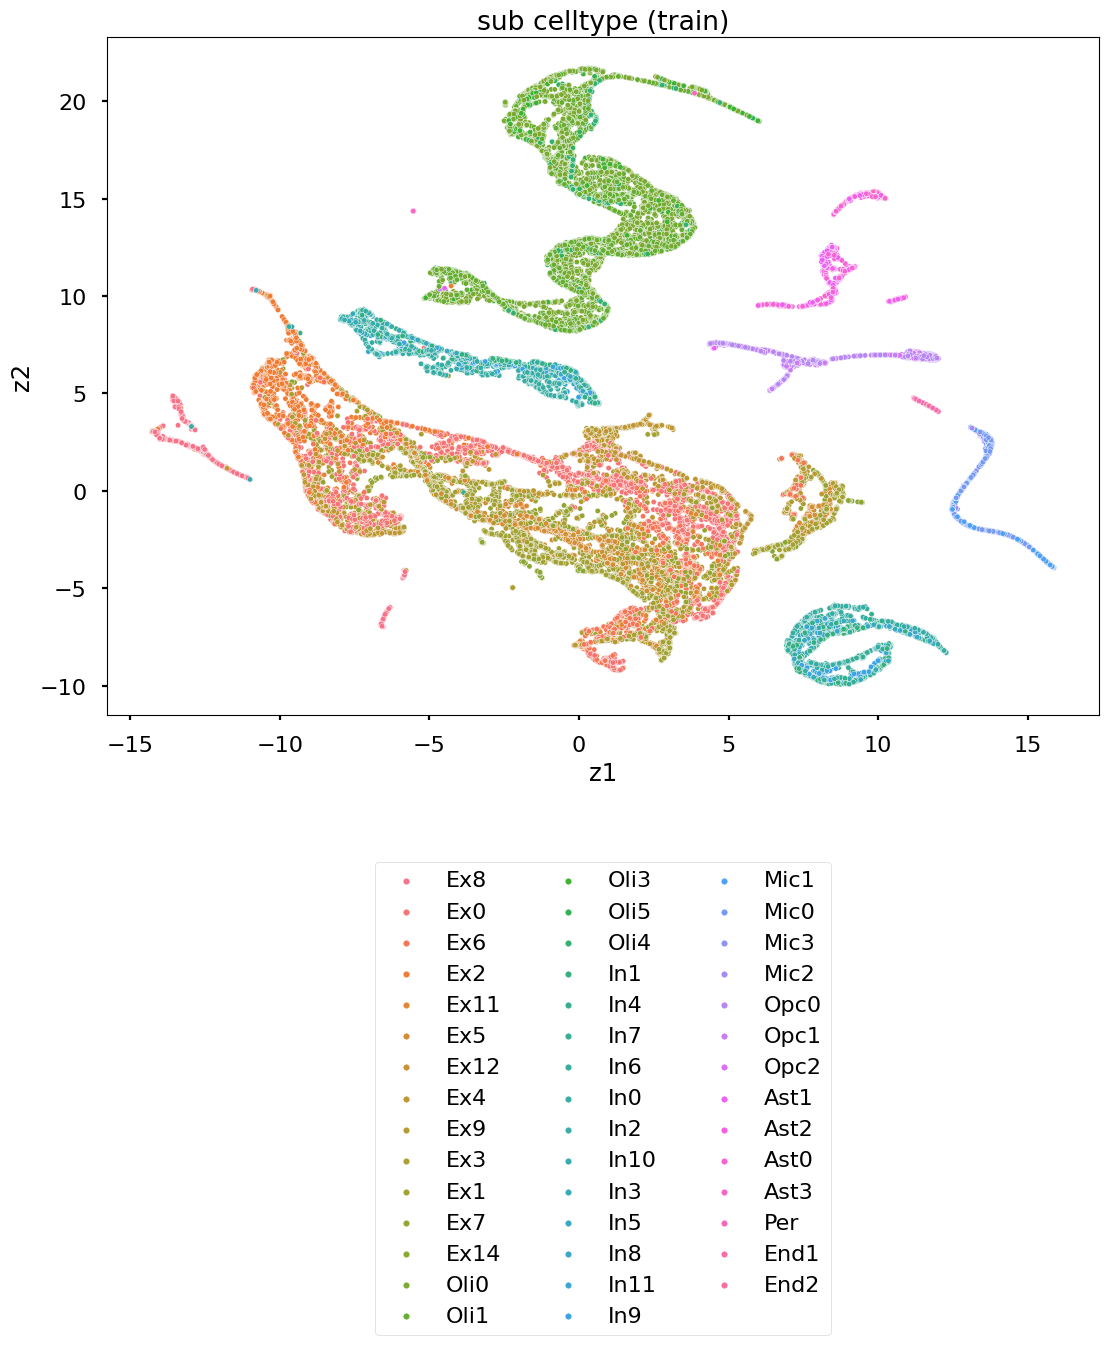

In [96]:
psc.plot_embedding(X=embd_train, y=lab_train['Subcluster'].values, label='subcelltype', title='sub celltype (train)', require_distinguishable_colors=False)

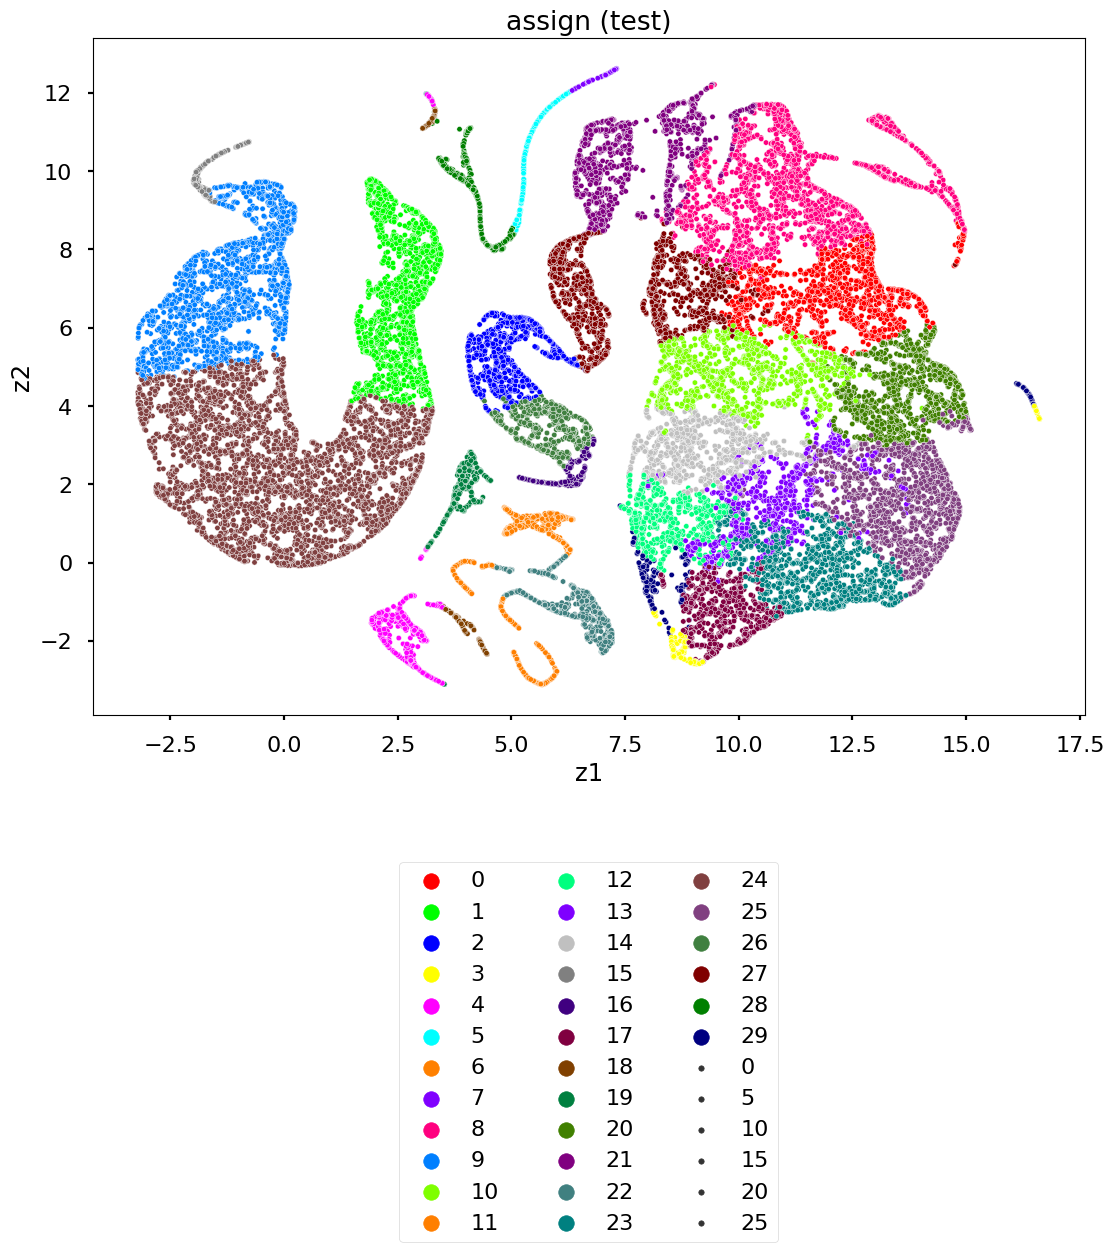

In [114]:
# on test data
lab_test['assign'] = psc.get_assigns(X_test)
psc.plot_embedding(X=embd_test, y=lab_test['assign'].values, label='assign', title='assign (test)', require_distinguishable_colors=True)

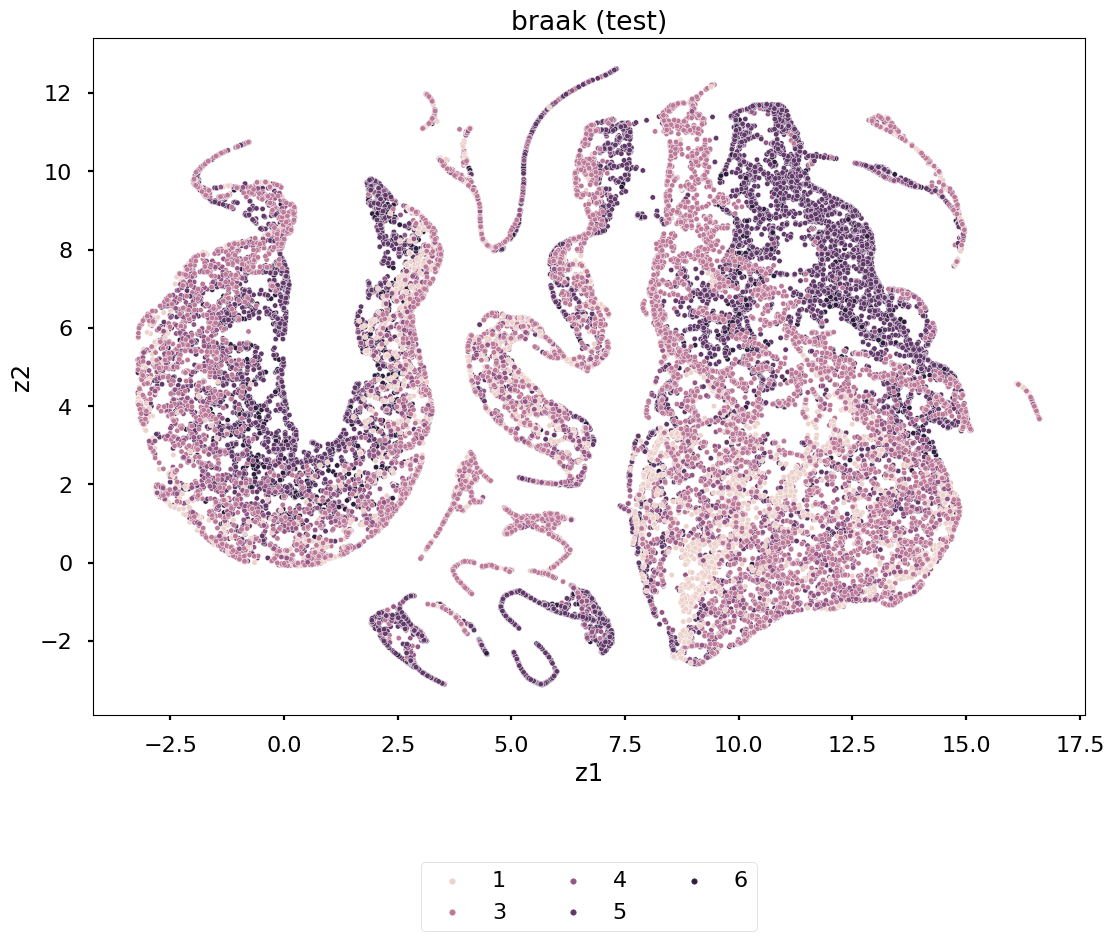

In [115]:
psc.plot_embedding(X=embd_test, y=lab_test['braaksc'].values, label='braak', title='braak (test)', require_distinguishable_colors=False)

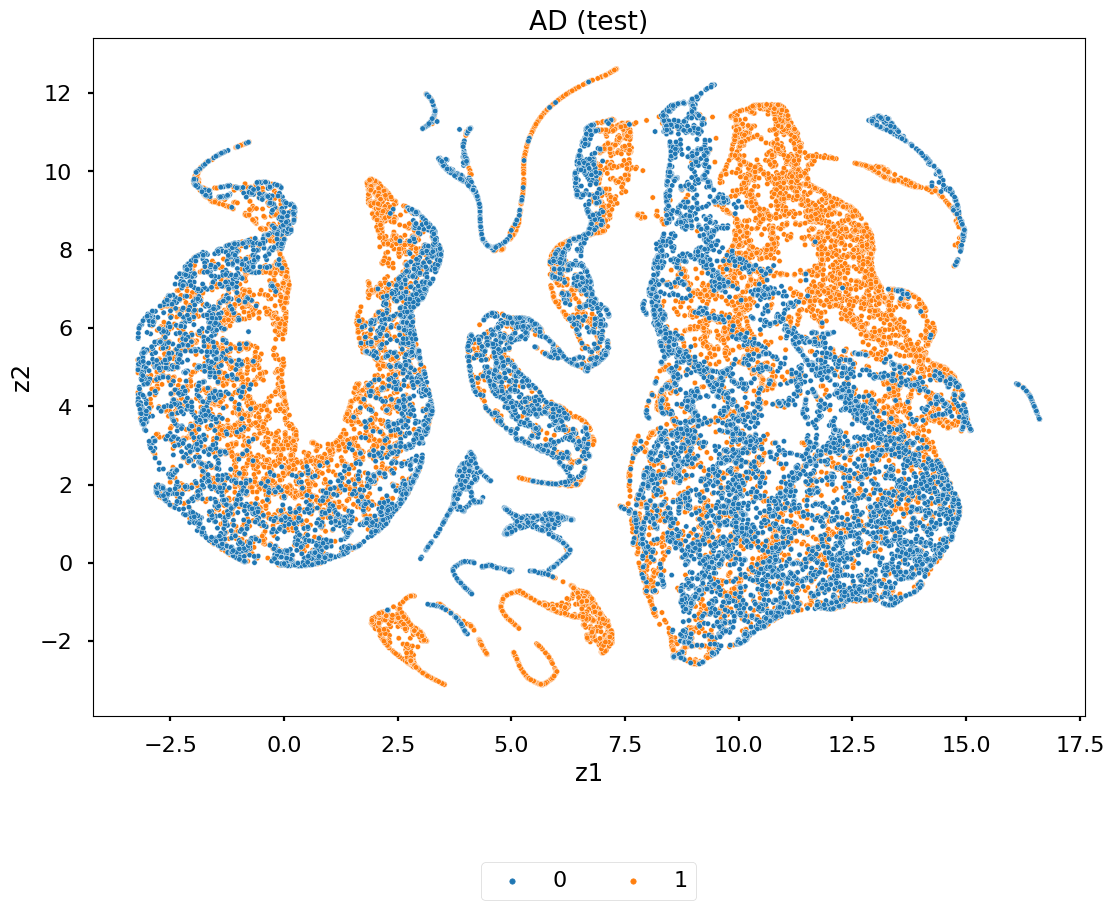

In [116]:
psc.plot_embedding(X=embd_test, y=lab_test['AD'].values, label='AD', title='AD (test)', require_distinguishable_colors=False)

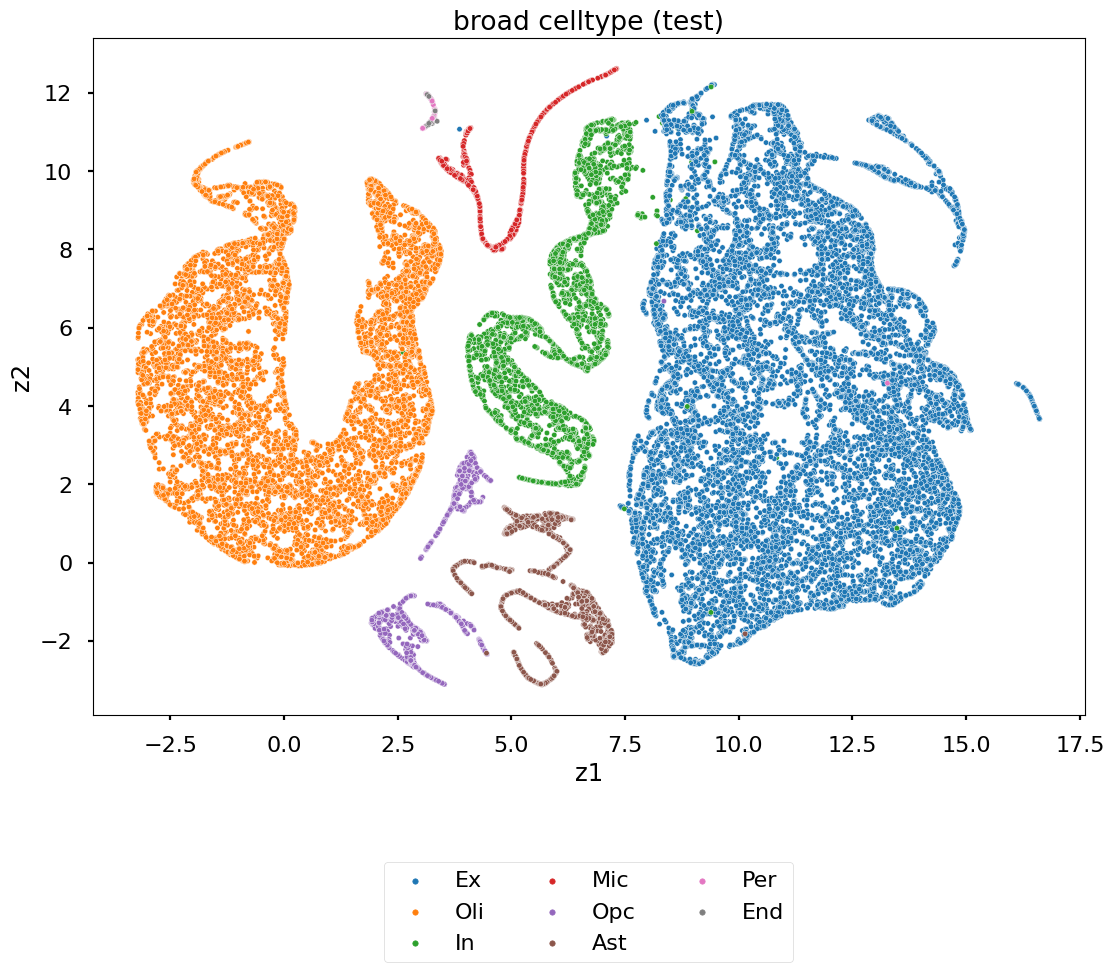

In [117]:
psc.plot_embedding(X=embd_test, y=lab_test['broad.cell.type'].values, label='broad celltype', title='broad celltype (test)', require_distinguishable_colors=False)

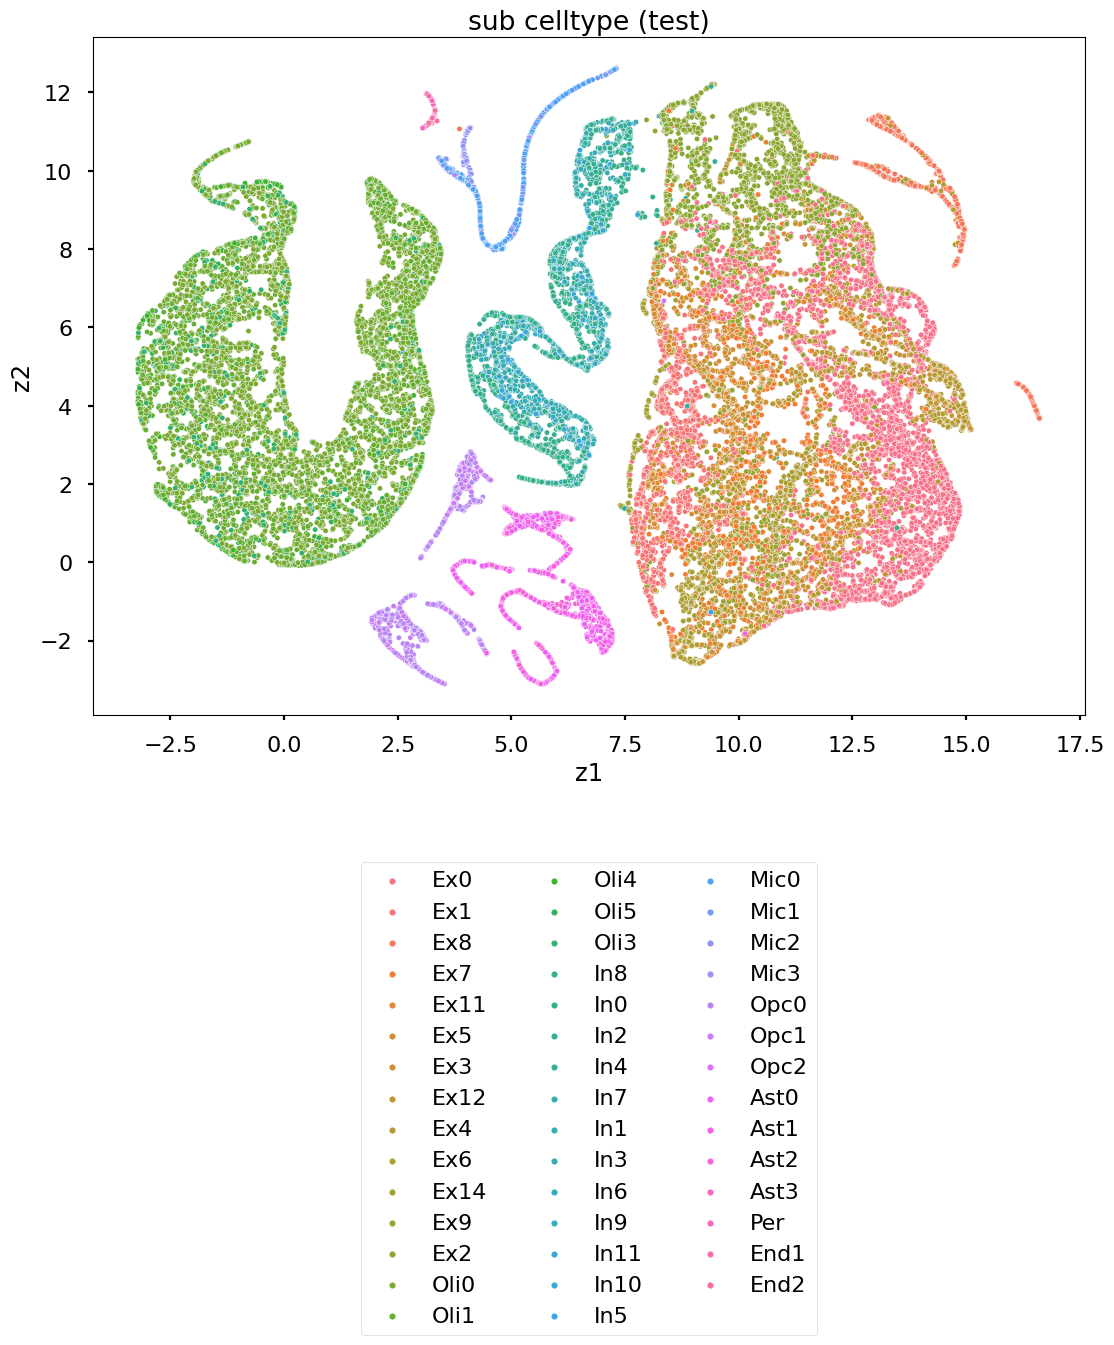

In [118]:
psc.plot_embedding(X=embd_test, y=lab_test['Subcluster'].values, label='subcelltype', title='sub celltype (test)', require_distinguishable_colors=False)